<a href="https://colab.research.google.com/github/YaelWeisman/Recidivism_ML_Projeect/blob/main/project_ML_unit3_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [ ]:
df = pd.read_parquet(r"C:\Users\user1\Downloads\data_part3")
df.head()

,new_id,sex,race,case_type,wcisclass,age_offense,age_judge,prior_felony,prior_misdemeanor,prior_criminal_traffic,...,max_hist_jail,min_hist_jail,avg_hist_jail,median_hist_jail,all_races,recid_180d_violent,county_name,Case_Duration_years,Case_Duration_month,ID
0,3.0,1,African American,Felony,Drug Offenses,40.0,41.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,['African American'],0.0,Milwaukee,1.0,0.1,1.0
1,6.0,1,Caucasian,Misdemeanor,Violent Crimes,39.0,40.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,['Caucasian'],0.0,Kenosha,1.0,0.1,2.0
2,7.0,1,African American,Misdemeanor,Violent Crimes,17.0,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,['African American'],0.0,Kenosha,0.0,0.0,3.0
3,12.0,1,Caucasian,Criminal Traffic,Traffic & Vehicle Offenses,65.0,65.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,['Caucasian'],0.0,Kenosha,0.0,0.0,4.0
4,17.0,1,African American,Criminal Traffic,Traffic & Vehicle Offenses,51.0,51.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,['African American' 'Caucasian'],0.0,Milwaukee,0.0,0.0,5.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476967 entries, 0 to 1476966
Data columns (total 51 columns):
 #   Column                    Non-Null Count    Dtype   
---  ------                    --------------    -----   
 0   new_id                    1476967 non-null  float64 
 1   sex                       1476967 non-null  int64   
 2   race                      1476967 non-null  category
 3   case_type                 1476967 non-null  category
 4   wcisclass                 1471484 non-null  category
 5   age_offense               1476967 non-null  float64 
 6   age_judge                 1476967 non-null  float64 
 7   prior_felony              1476967 non-null  float64 
 8   prior_misdemeanor         1476967 non-null  float64 
 9   prior_criminal_traffic    1476967 non-null  float64 
 10  highest_severity          1476967 non-null  float64 
 11  release                   1476967 non-null  int64   
 12  probation                 1032320 non-null  float64 
 13  is_recid_new

In [ ]:
df.shape

(1476967, 51)

In [ ]:
#change type to  binary columns
bin_cols=['sex','release','probation','is_recid_new','recid_180d','recid_180d_violent']
for col in bin_cols:
  df[col]=df[col].astype('category')

##### 📉 **Visualization of Missing Data Patterns**

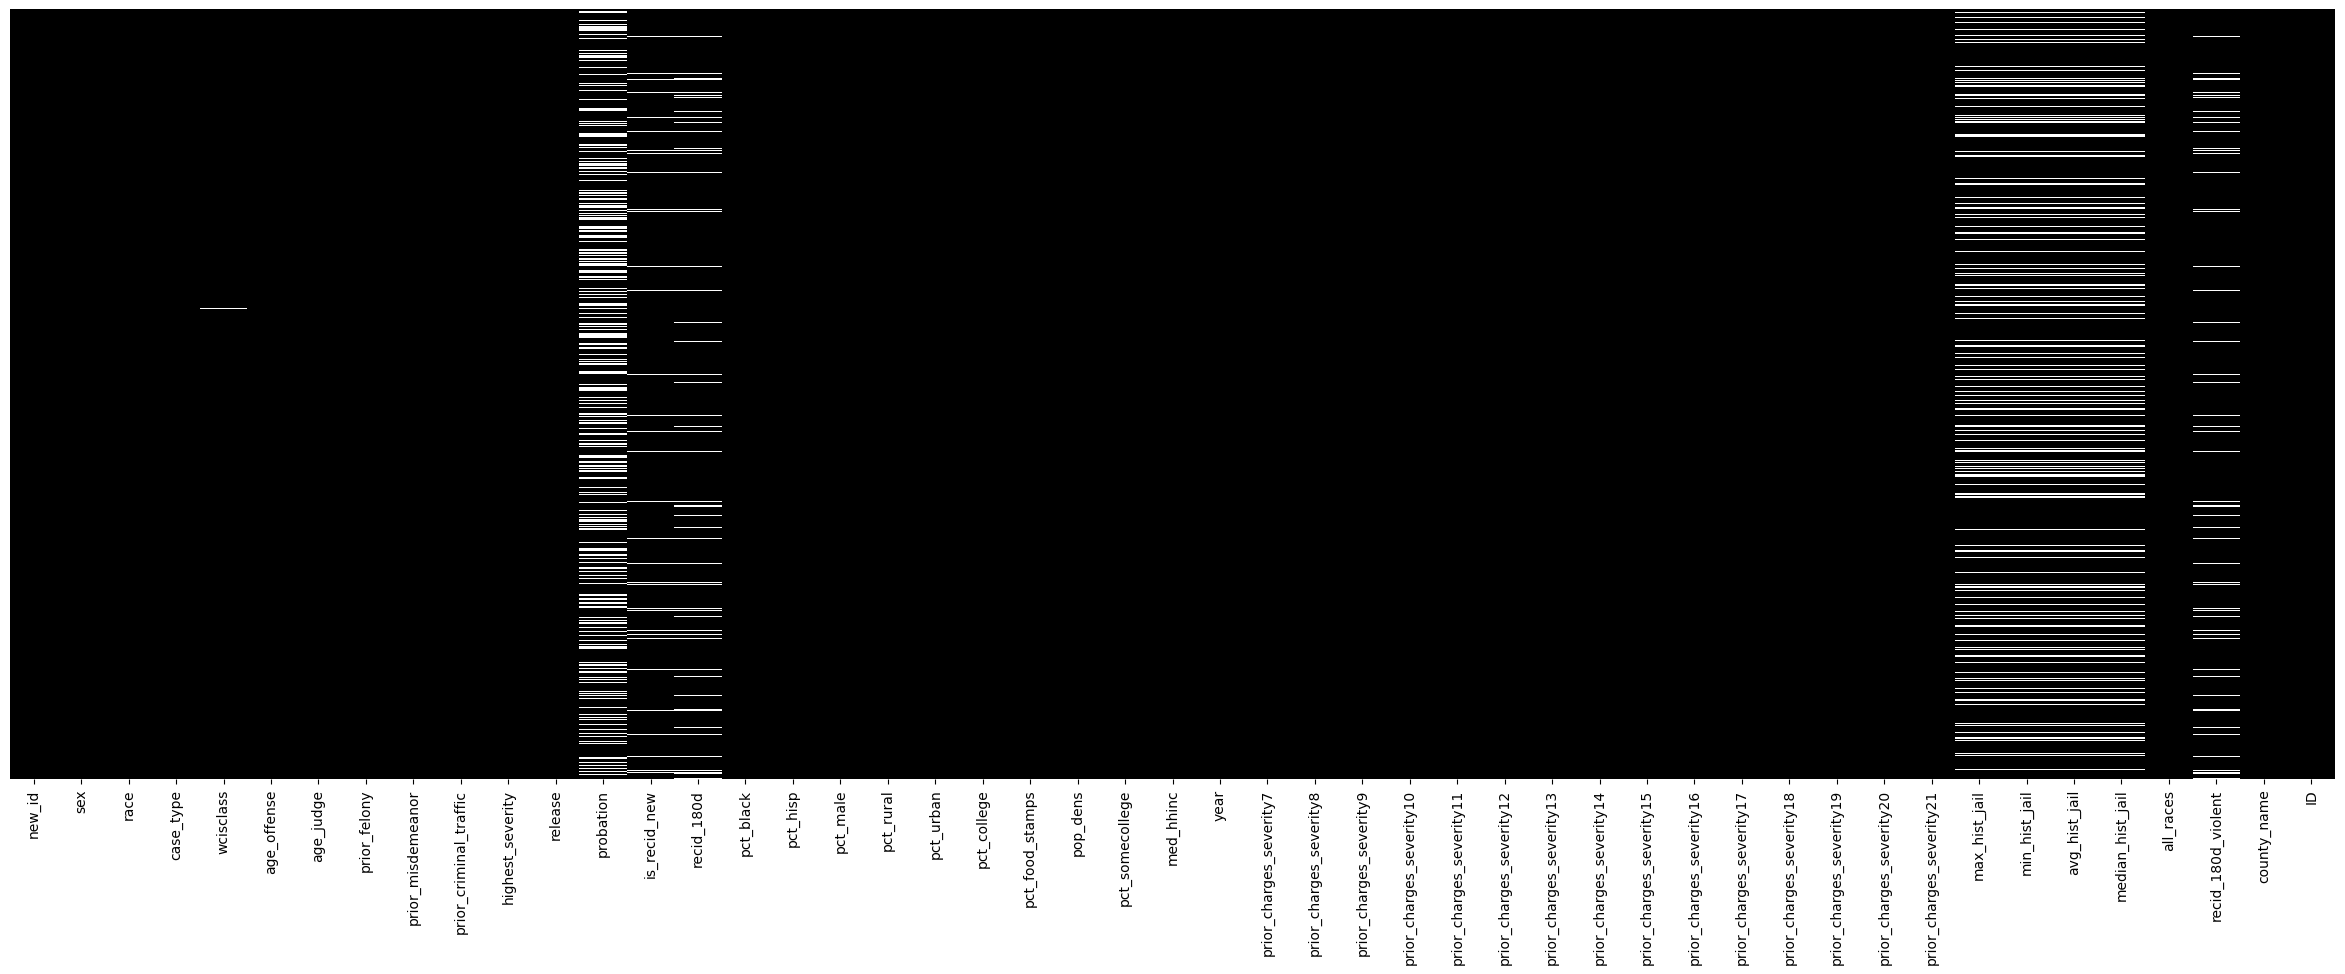

In [ ]:

plt.figure(figsize=(30,10))
sns.heatmap(df.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='Greys_r')
plt.show()

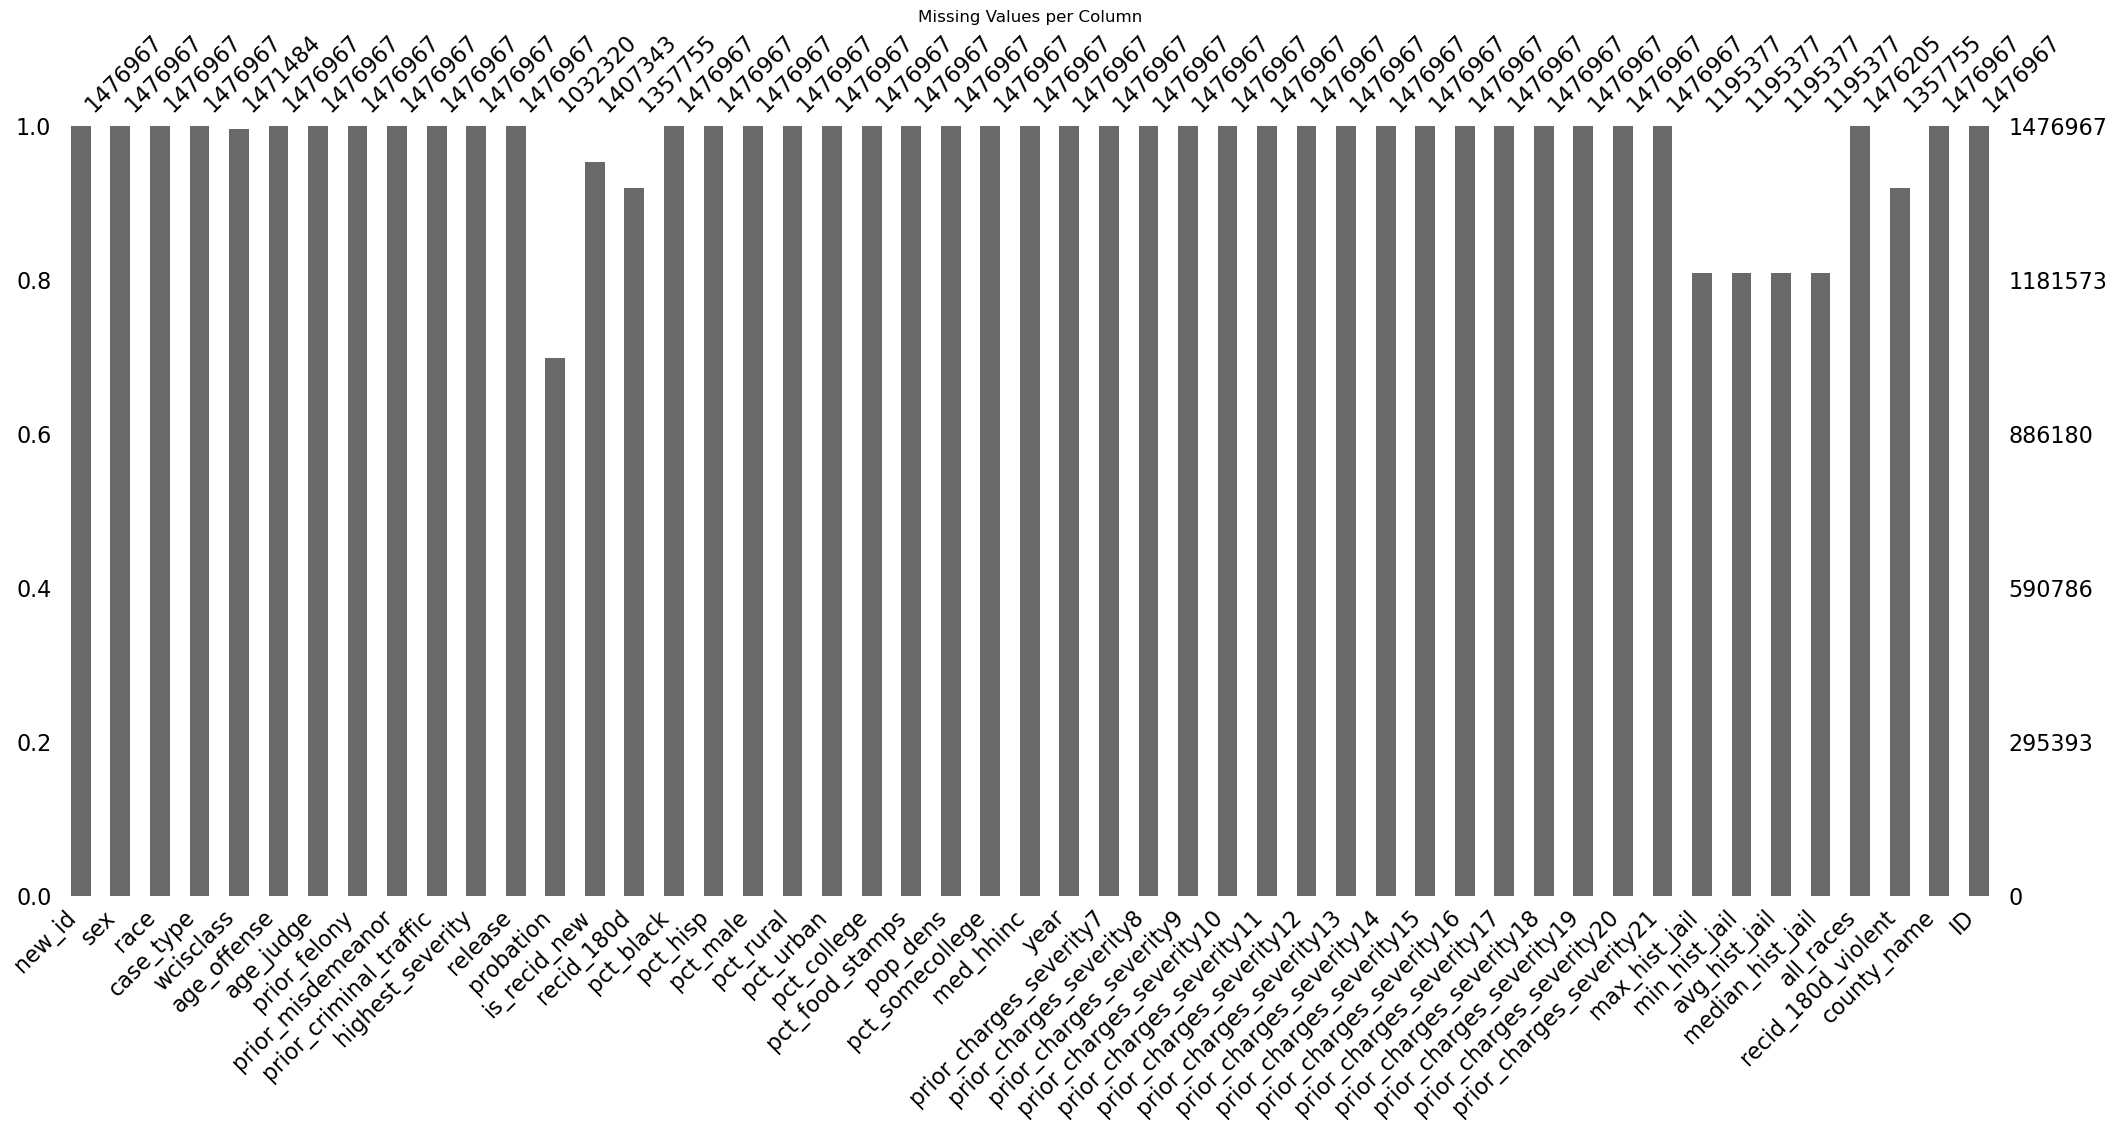

In [ ]:
#!pip install missingno
import missingno as msno
plt.figure(figsize=(14,5))
msno.bar(df)
plt.title("Missing Values per Column")
plt.show()

In [ ]:
con_df=df.select_dtypes(include='float64') #Numeric cols
cat_col=df.select_dtypes(include=['category','string']) #sting ,category colls

#### 📉 **Box Plots Showing Distribution and Outliers for Each Numeric Feature**

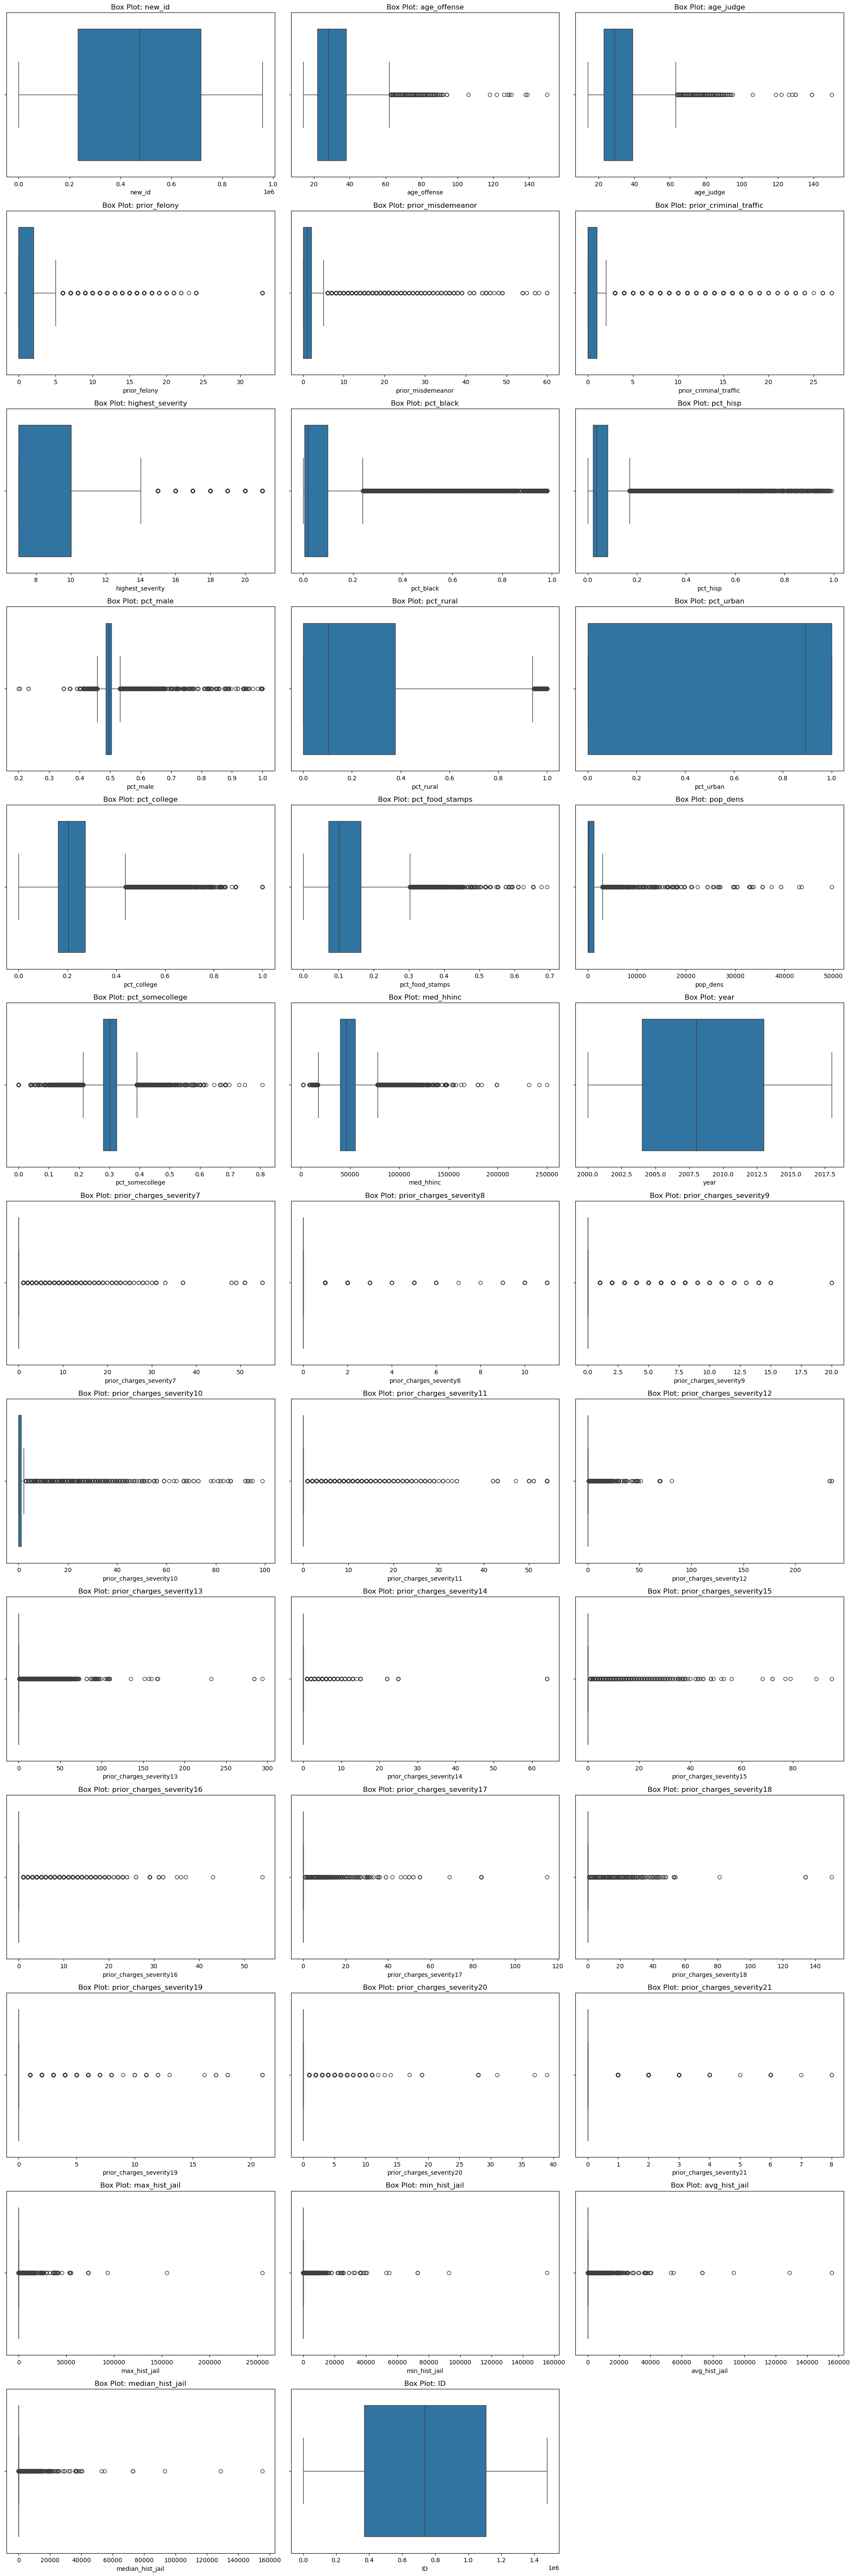

In [ ]:
def outliers_boxplot(df):
    plt.figure(figsize=(20, 60))
    numeric_cols = df.select_dtypes(include=['number']).columns
    for i, col in enumerate(numeric_cols):
        ax = plt.subplot(len(numeric_cols)//3 + 1, 3, i+1)
        sns.boxplot(data=df, x=col, ax=ax)
        plt.title(f'Box Plot: {col}', fontsize=12)
        plt.xlabel(col, fontsize=10)
    plt.tight_layout()
    plt.show()
outliers_boxplot(con_df)

In [ ]:
#skewness for numeric cols
skew_df = pd.DataFrame(con_df.skew(), columns=['skewness']).sort_values(by='skewness', ascending=False)
skew_df.style.background_gradient(cmap='coolwarm', axis=None)

,skewness
prior_charges_severity8,111.802798
prior_charges_severity21,71.253269
min_hist_jail,56.207222
prior_charges_severity12,55.794119
max_hist_jail,52.554988
median_hist_jail,50.692494
avg_hist_jail,48.915951
prior_charges_severity20,44.148715
prior_charges_severity19,43.315404
prior_charges_severity14,26.076851


#### 🧭 **Decision**

Since most distributions are **not normal**, outliers will be identified —  
and, if necessary, removed using the **IQR (Interquartile Range)** method.

In [ ]:
# Function to detect and calculate outliers using the IQR method
# Returns a summary table with the count and percentage of outliers for each numeric column

def outliers_df(df):
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])

    for col in df:
        temp = pd.DataFrame(df[col])
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR
        temp_outliers = temp[(temp[col] > upper_limit) | (temp[col] < lower_limit)]
        num_outliers = len(temp_outliers)
        total_outliers.loc[col] = [num_outliers, num_outliers / len(df) * 100]

    return total_outliers[total_outliers['Percent'] > 0]
## drop the cloumns which got skewness closer to 1 that indicates of normal distribution.
outliers_result = outliers_df(
    con_df.drop(columns=['year', 'new_id', 'ID'], errors='ignore')
).sort_values('Percent', ascending=False)

outliers_result


,Outlier count,Percent
avg_hist_jail,296231.0,20.056711
max_hist_jail,296231.0,20.056711
median_hist_jail,288194.0,19.512555
prior_charges_severity13,240915.0,16.311468
min_hist_jail,234138.0,15.852622
pct_black,219502.0,14.861673
prior_charges_severity7,212720.0,14.402488
pct_rural,196091.0,13.276600
prior_charges_severity12,170054.0,11.513731
prior_charges_severity10,151597.0,10.264075


In [ ]:
# 'year' shows a normal distribution, so outliers will be detected using the Z-score method
# Dropping 'year', 'new_id', and 'ID' columns before erasing outliers
z_score_col = 'year'
con_df = con_df.drop(columns=z_score_col)
con_df = con_df.drop(columns=['new_id', 'ID'])

<!-- ## Outliers
there is a conflicts  this details are statistic details like median,avg etc ,so maby they really introduce a group of population
## Desicion -not to delete outliers in details of past jail -->

In [ ]:
(df.avg_hist_jail>0).mean()#just like the outliers..

np.float64(0.20056710813444037)

In [ ]:
df[df.avg_hist_jail>0].shape,df[df.max_hist_jail>0].shape,df[df.median_hist_jail>0].shape,df[df.min_hist_jail>0].shape

((296231, 49), (296231, 49), (288194, 49), (234138, 49))

In [ ]:
df.avg_hist_jail.median(),df.avg_hist_jail.mean() ,(df['avg_hist_jail'] > 0).mean()
# most values are 0 most offense didnot sat i jail will it so every offense that sat becames outliers

(0.0, np.float64(129.0958491665762), np.float64(0.20056710813444037))

In [ ]:
(df.prior_charges_severity21>0).mean()
# 16% of offense  who have previously been charged with a criminal offense classified at severity level 13.
#and in the outliers :16% outliers so i wount drop the outliers couse this is exactly where i want to focous


np.float64(0.0008043510789340587)

In [ ]:
(df.pct_black>0).mean()# more than 99% is full do the data has realy outliers -drop outlier and so on all the detals of demograph

np.float64(0.9906639755661433)

In [ ]:
(df.prior_criminal_traffic>0).sum(),(df.prior_felony>0).sum(),(df.prior_misdemeanor>0).sum()

(np.int64(478645), np.int64(665169), np.int64(783967))

In [ ]:
(df.prior_criminal_traffic>0).sum()

np.int64(478645)

In [ ]:
(df['highest_severity'] > 0).sum()

np.int64(1476967)

In [ ]:
df['prior_criminal_traffic'].describe()

count    1.476967e+06
mean     7.373198e-01
std      1.514619e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.700000e+01
Name: prior_criminal_traffic, dtype: float64

In [ ]:
col_for_outliers=['age_judge','age_offense','pct_food_stamps','med_hhinc','pct_college','pct_somecollege','pop_dens','pct_hisp','pct_male','pct_rural','pct_black','prior_felony','prior_misdemeanor','highest_severity','prior_criminal_traffic']

### 📊 **Outlier Analysis Summary**

Most columns exhibited **high skewness**, with 80–90% of identical values.  
As a result, the **IQR method** detected an artificially high percentage of outliers,  
classifying almost all values different from the dominant one as outliers.  

After reviewing these variables, it was decided **not to remove the outliers**,  
but instead to **group them into bins** later — to highlight meaningful differences  
while minimizing bias and avoiding unnecessary noise.


In [ ]:
# function to mark the ouliers by 1 ot outliers-0
def outliers(df):
    label_out_df = df.copy()
    for col in label_out_df:
        if col in outliers_result.index:
            Q1 = label_out_df[col].quantile(0.25)
            Q3 = label_out_df[col].quantile(0.75)
            upper_limit = Q3 + 1.5 * (Q3 - Q1)
            lower_limit = Q1 - 1.5 * (Q3 - Q1)
            label_out_df[col] = np.where(
                label_out_df[col] > upper_limit, 'Outlier',
                np.where(label_out_df[col] < lower_limit, 'Outlier', label_out_df[col])
            )
    return label_out_df
new_df_outliers = outliers(df[col_for_outliers])
df_outliers = new_df_outliers.isin(['Outlier'])
df_outliers = df_outliers.astype('int')


In [ ]:
df_outliers.sample(10)

,age_judge,age_offense,pct_food_stamps,med_hhinc,pct_college,pct_somecollege,pop_dens,pct_hisp,pct_male,pct_rural,pct_black,prior_felony,prior_misdemeanor,highest_severity,prior_criminal_traffic
1245766,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1001786,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9920,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1108420,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
788294,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
1472352,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1205107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
199976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
958307,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1030630,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## now check the outlires and get the decision if to drop or not

In [ ]:
#function to drop outliers
def capping(df):
    temp = df.copy()
    for col in temp:
        if col in outliers_result.index:
            Q1 = temp[col].quantile(0.25)
            Q3 = temp[col].quantile(0.75)
            upper_limit = Q3 + 1.5 * (Q3 - Q1)
            lower_limit = Q1 - 1.5 * (Q3 - Q1)
            temp[col] = np.where(temp[col] > upper_limit,np.nan,np.where(temp[col] < lower_limit,np.nan,temp[col]))
    return temp
temp = capping(df[col_for_outliers])
temp

,age_judge,age_offense,pct_food_stamps,med_hhinc,pct_college,pct_somecollege,pop_dens,pct_hisp,pct_male,pct_rural,pct_black,prior_felony,prior_misdemeanor,highest_severity,prior_criminal_traffic
0,41.0,40.0,0.260798,34942.0,0.100519,NaN,NaN,NaN,0.501354,0.000000,0.065477,0.0,0.0,7.0,0.0
1,40.0,39.0,0.103472,67610.0,0.156819,0.387588,94.848392,0.041999,0.506768,0.260448,0.004050,0.0,0.0,9.0,0.0
2,17.0,17.0,0.184196,45428.0,0.206234,0.294273,2152.558314,NaN,0.487577,0.000000,0.110342,0.0,0.0,9.0,0.0
3,NaN,NaN,0.184196,45428.0,0.206234,0.294273,2152.558314,NaN,0.487577,0.000000,0.110342,0.0,0.0,7.0,0.0
4,51.0,51.0,NaN,22838.0,0.081314,0.268765,2747.843899,0.043682,NaN,0.000000,NaN,1.0,0.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476962,17.0,17.0,0.092599,42174.0,0.322574,0.330988,258.721312,0.016781,0.477395,0.090162,0.018181,0.0,0.0,10.0,0.0
1476963,34.0,33.0,0.071631,62920.0,0.236056,0.345269,92.180419,0.035978,0.499297,0.319077,0.005989,0.0,0.0,7.0,0.0
1476964,31.0,31.0,0.228291,35249.0,0.263994,0.286192,819.726500,NaN,0.511560,0.000294,0.192089,0.0,0.0,7.0,0.0
1476965,18.0,17.0,0.129915,50080.0,0.176199,0.274306,NaN,NaN,0.494626,0.000000,0.059561,0.0,0.0,7.0,0.0


In [ ]:
# Function to compare two correlation coefficients using Fisher's Z-test
# Calculates the Z statistic and p-value to test whether two Spearman correlations differ significantly
def cocor(x1,y1, x2,y2):
    xy1 = x1.corr(y1, method='spearman')
    xy2 = x2.corr(y2, method='spearman')
    n1 = len(x1)
    n2 = len(x2)
    xy_z = 0.5 * np.log((1 + xy1)/(1 - xy1))
    ab_z = 0.5 * np.log((1 + xy2)/(1 - xy2))
    if n2 is None:
        n2 = n1
    se_diff_r = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
    diff = xy_z - ab_z
    z = abs(diff / se_diff_r)
    p = (1 - norm.cdf(z)) * 2
    return z, p

In [ ]:
#This code is checking the corr and distribution without and whith the outliers if the corr and distribution change drop other dont drop
from scipy.stats import norm, ks_2samp
names = col_for_outliers
# Creating df that reflects the correlation change
out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])
# A copy of numeric df
no_outliers = con_df.copy()
np.seterr(divide='ignore', invalid='ignore')
rows = []
for i in names:
    # Data with outliers
    out = df[i]
    # Data without outliers
    non = df[i].loc[df_outliers[i] == 0]
    # Labels with outliers
    survived_out = df['is_recid_new']
    # Labels without outliers
    survived_non = df['is_recid_new'].loc[df_outliers[i] == 0]

    # Correlation p-value
    p, pvalue = cocor(out, survived_out, non, survived_non)
    cor_change = np.where(pvalue < 0.05, '+', '-')
    # Outliers count
    mv = df_outliers.sum()
    # KS test p-value
    pval = ks_2samp(out, non)[1]
    dist_change = np.where(pval < 0.05, '+', '-')

    # Append the data as a dictionary
    rows.append({
        'feature': i,
        'outliers_cnt': mv,
        'distribution_changed': dist_change,
        'correlation_changed': cor_change
    })
# Use pd.DataFrame to create out_df from rows
out_df = pd.DataFrame(rows)

In [ ]:
out_df['drop']='yes'
out_df.loc[(out_df.distribution_changed=='+')& (out_df.correlation_changed=='+'),'drop'] = 'no'
out_df.head(30)

,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,age_judge,age_judge 10001 age_offense ...,+,+,no
1,age_offense,age_judge 10001 age_offense ...,+,+,no
2,pct_food_stamps,age_judge 10001 age_offense ...,+,+,no
3,med_hhinc,age_judge 10001 age_offense ...,+,+,no
4,pct_college,age_judge 10001 age_offense ...,+,+,no
5,pct_somecollege,age_judge 10001 age_offense ...,+,+,no
6,pop_dens,age_judge 10001 age_offense ...,+,+,no
7,pct_hisp,age_judge 10001 age_offense ...,+,+,no
8,pct_male,age_judge 10001 age_offense ...,+,+,no
9,pct_rural,age_judge 10001 age_offense ...,+,+,no


#### There is no outliers to drop

## z_score:

In [ ]:
from scipy import stats
from scipy.stats import zscore

In [ ]:
col='year'
z_scores = (df[col] - df[col].mean()) / df[col].std()
df.loc[z_scores.abs() > 2.5, col] = np.nan

In [ ]:
#null in precents
df.isnull().sum()

new_id                           0
sex                              0
race                             0
case_type                        0
wcisclass                     5483
age_offense                      0
age_judge                        0
prior_felony                     0
prior_misdemeanor                0
prior_criminal_traffic           0
highest_severity                 0
release                          0
probation                   444647
is_recid_new                 69624
recid_180d                  119212
pct_black                        0
pct_hisp                         0
pct_male                         0
pct_rural                        0
pct_urban                        0
pct_college                      0
pct_food_stamps                  0
pop_dens                         0
pct_somecollege                  0
med_hhinc                        0
year                             0
prior_charges_severity7          0
prior_charges_severity8          0
prior_charges_severi

In [ ]:
df.to_pickle("df_unit4_to_impute.pkl")